# Linearized deformation example

We show some capabilities of ODL in a conceptually complex application.

### Problem:
For $\mathscr{X} = L^2(\Omega)$ (image space) and $\mathscr{Y} = L^2(M)$ (data space, $M$ corresponds to some manifold depending on the acquisition geometry), calculate

$$
\alpha^* \in \mathrm{arg}\min_{\alpha \in \mathbb{R}^{2N}} \mathcal{S}(\alpha)\\
\mathcal{S}(\alpha) := \frac{1}{2} \big\lVert \mathcal{T}\big( \mathcal{W}_I(\alpha) \big) - g \big\rVert_{\mathscr{Y}}^2
$$

with the *template deformation operator*

$$
\mathcal{W}_I: \mathbb{R}^{2N} \to \mathscr{X}\\
\mathcal{W}_I(\alpha) := I\big( \cdot + v_\alpha(\cdot) \big)
$$

The template $I \in \mathscr{X}$ is fixed.

### Goal:
Build a pipeline for a gradient-based method *without hard-coding the components*. In particular: a method to evaluate $\nabla S(\alpha)$.

### Solution:
We identify the following 3 parts:
 
- $L^2$ data matching functional
  $$
  \mathcal{D}_g: \mathscr{Y} \to \mathbb{R}\\
  \mathcal{D}_g(f) := \frac{1}{2} \lVert f - g \rVert_{\mathscr{Y}}^2
  $$

- Forward operator $\mathcal{T}: \mathscr{X} \to \mathscr{Y}$ (a tomographic projection from our library)

- Template deformation operator $\mathcal{W}_I: \mathbb{R}^{2N} \to \mathscr{X}$

The functional $\mathcal{S}$ can be written as $\mathcal{S} = \mathcal{D}_g \circ \mathcal{T} \circ \mathcal{W}_I$, so we can use the chain rule

$$
\nabla \mathcal{S}(\alpha) = \left[ \mathcal{W}_I'(\alpha)^\ast \circ \mathcal{T}'\big( \mathcal{W}_I(\alpha) \big)^\ast \right]
\nabla \mathcal{D}_g\big( \mathcal{T}(\mathcal{W}_I(\alpha) \big) \big)
$$

### How ODL helps simplifying the task

- **ODL knows the chain rule**

  The derivative of the inner operator $\mathcal{T} \circ \mathcal{W}_I$ will be correctly evaluated as

  $$
  (\mathcal{T} \circ \mathcal{W}_I)'(\alpha)(\beta) = \mathcal{T}'\big( \mathcal{W}_I(\alpha) \big) \mathcal{W}_I'(\alpha)(\beta).
  $$


- **Adjoints of compositions are handled correctly**

  The adjoint of a composition $\mathcal{A} \circ \mathcal{B}$ is calculated as $\mathcal{B}^\ast \circ \mathcal{A}^\ast$.


- **In development: gradients are handled accordingly**

  ODL will evaluate the whole chain rule for the gradient automatically from the parts $\mathcal{W}_I$, $\mathcal{W}_I'(\alpha)$, $\mathcal{W}_I'(\alpha)^\ast$, $\mathcal{T}$, $\mathcal{T}'(f)$, $\mathcal{T}'(f)^\ast$ and $\nabla \mathcal{D}_g$.
  

In [1]:
import odl
import numpy as np

## 1. The data matching functional

Implementation of this functional is very easy - we can use the built-in space arithmetic and the `norm` method.

For simplicity, we consider the functional on the image space $\mathscr{X} = L^2([-1, 1] \times [0, 1])$:

In [2]:
X = odl.uniform_discr([-1, 0], [1, 1], (500, 500))  # create a uniformly discretized L^2 space

We can create a Shepp-Logan phantom in this space:

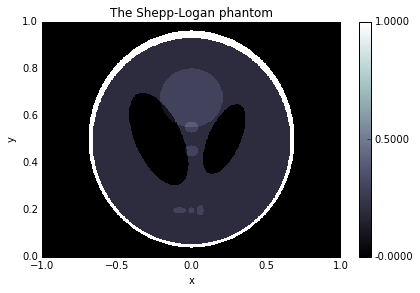

In [21]:
phantom = odl.util.phantom.shepp_logan(X, modified=True)

% matplotlib inline
fig = phantom.show('The Shepp-Logan phantom')

Now we write the functional and test it with our phantom:

In [15]:
class L2DataMatchingFunctional(odl.Functional):

    def __init__(self, space, data):
        super().__init__(space)
        self.data = data  # We just store the data
    
    # This method needs to be implemented by the user - it is never called explicitly
    def _call(self, func):
        return (func - self.data).norm() ** 2 / 2
    

In [10]:
l2_func = L2DataMatchingFunctional(space=X, data=phantom)

Functionals are called in the same way as operators - with parentheses:

In [12]:
l2_func(phantom)

0.0

In [13]:
l2_func(X.one())

0.814325

### Adding a gradient evaluation method

Since we want to use a gradient-based approach, we need a way to evaluate the functional gradient. Of course, it is

$$
\nabla \mathcal{D}_g(f) = f - g,
$$

which is also very simple to implement:

In [17]:
class L2DataMatchingFunctional(odl.Functional):

    def __init__(self, space, data):
        super().__init__(space)
        self.data = data  # We just store the data
    
    # This method needs to be implemented by the user - it is never called explicitly
    def _call(self, func):
        return (func - self.data).norm() ** 2 / 2
    
    def gradient(self, func):  # preliminary interface
        return func - self.data
    

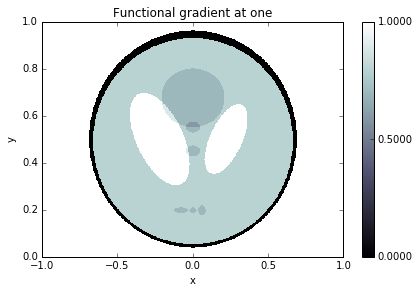

In [20]:
l2_func = L2DataMatchingFunctional(space=X, data=phantom)

grad_at_one = l2_func.gradient(X.one())  # 1 - phantom
fig = grad_at_one.show('Functional gradient at one')

## 2. The forward operator

We use a parallel beam 2D forward projection from the ASTRA toolbox:

In [22]:
# Forward operator code goes here

## 3. The deformation operator

$$
\mathcal{W}_I(\alpha) = I\big( \cdot + v_\alpha(\cdot) \big)
$$

The implementation of the evaluation of this operator is more complex. It involves three steps:

1. Compute the displacement field $v_\alpha(y_i)$ for all image grid points $y_i$
2. Compute the warped grid points $\tilde y_i = y_i + v_\alpha(y_i)$
3. Interpolate the template $I$ at the warped grid points

In code, it looks like this:

In [ ]:
class TemplateDeformation(odl.Operator):

    # Initialization code goes here

    def deform(self, template, alphas):
        image_points = self.image_grid.points()  # Array of all grid points
        displacement = self.displacement(alphas)

        # Loop per component, not per point
        for i, v in enumerate(displacement):
            image_points.T[i] += v

        return template.interpolation(image_points.T, bounds_check=False)

#### Example: Deforming the Shepp-Logan phantom

We use a phantom on the rectangle $[-1/2, 1/2]^2$ as template:

In [40]:
image_space = odl.uniform_discr([-0.5, -0.5], [0.5, 0.5], (500, 500))
template = odl.util.phantom.shepp_logan(image_space, modified=True)

The control points are chosen as a $5\times 5$ grid:

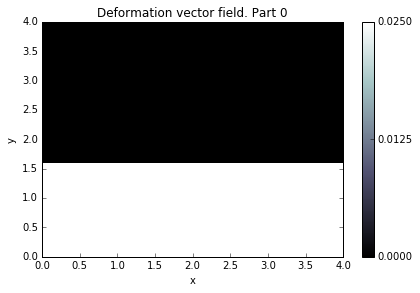

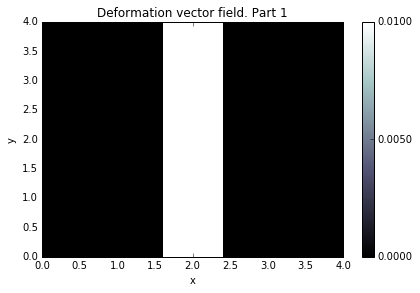

In [36]:
n = 5  # n^2 = number of control points for deformation
alpha_i_space = odl.uniform_discr([-0.5, -0.5], [0.5, 0.5], [n, n])  # Components of the coefficients alpha
coeff_space = odl.ProductSpace(coeff_space, 2)  # 2D vector field -> product space of 2 factors

# Create deformation field
alpha_array = np.zeros([2, n, n])
alpha_array[0, :, :n // 2] = 0.025  # movement in "x" direction
alpha_array[1, n // 2, :] = 0.01   # movement in "y" direction
alpha = vspace.element(alpha_array)

fig = alpha.show('Deformation vector field')

For the displacement, we use a Gaussian kernel of width $\sigma = 0.3$, i.e.

$$
K_i(x) = K(x) = \left[ \exp \left( -\frac{\lvert x - x_j\rvert}{2\sigma^2} \right) \right]_{j=1}^{N}
$$

with $N = 25$.

[array([ 0.07325747,  0.07354512,  0.07383096, ...,  0.00376764,
        0.00370741,  0.00364799]), array([ 0.00472334,  0.00474881,  0.00477429, ...,  0.00477429,
        0.00474881,  0.00472334])]

[-0.42574253 -0.42545488 -0.42516904 ...,  0.50276764  0.50270741
  0.50264799]

[-0.49427666 -0.49225119 -0.49022571 ...,  0.49977429  0.50174881
  0.50372334]


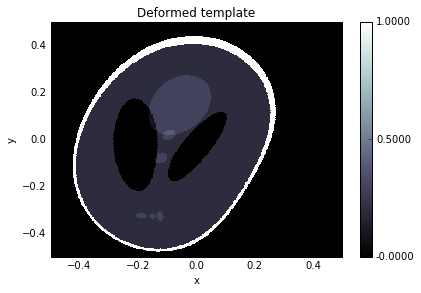

In [42]:
def gauss_kernel(x):
    return np.exp(-x ** 2 / (2 * 0.3 ** 2))

deformation = odl.TemplateDeformationOperator(vspace, alpha_i_space.grid, template, gauss_kernel)

deformed_template = deformation(alpha)
fig = deformed_template.show('Deformed template')

### Derivative

The derivative of $\mathcal{W}_I$ is given by ($v_\beta$ is linear in $\beta$)

$$
\mathcal{W}_I'(\alpha): \mathbb{R}^{2N} \to \mathscr{X} \\
\mathcal{W}_I'(\alpha)(\beta) = v_\beta(\cdot)^{\mathrm{T}} \nabla I( \cdot + v_\alpha(\cdot)).
$$


### Adjoint of the derivative

With $\alpha_1, \alpha_2 \in \mathbb{R}^N$ and the kernel functions $K_i: \mathbb{R}^2 \to \mathbb{R}^N$, one can write

$$
v_\alpha(x) =
\begin{pmatrix}
  K_1(x)^{\mathrm{T}} \alpha_1 \\
  K_2(x)^{\mathrm{T}} \alpha_2
\end{pmatrix}
$$

Then one can show that

$$
\mathcal{W}_I'(\alpha)^\ast: \mathscr{X} \to \mathbb{R}^{2N} \\
\mathcal{W}_I'(\alpha)^\ast(f) = \int_\Omega f(x) 
\begin{pmatrix}
  K_1(x) \partial_1 I(x + v_\alpha(x)) \\
  K_2(x) \partial_2 I(x + v_\alpha(x))
\end{pmatrix}\ \mathrm{d}x.
$$

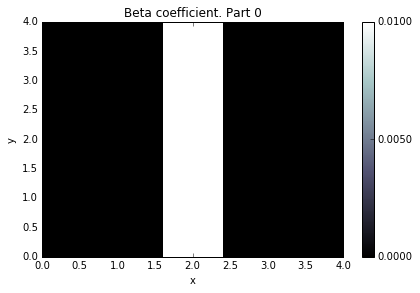

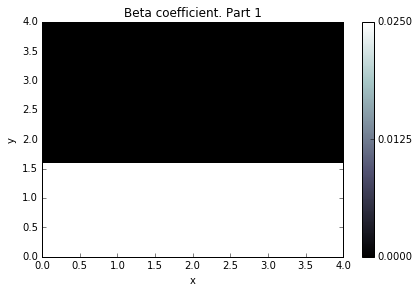

In [45]:
# Another deformation field for testing
beta_array = np.zeros([2, n, n])
beta_array[0, n // 2, :] = 0.01   # movement in "x" direction
beta_array[1, :, :n // 2] = 0.025  # movement in "y" direction
beta = vspace.element(beta_array)

fig = beta.show('Beta coefficient')

[array([ 0.07325747,  0.07354512,  0.07383096, ...,  0.00376764,
        0.00370741,  0.00364799]), array([ 0.00472334,  0.00474881,  0.00477429, ...,  0.00477429,
        0.00474881,  0.00472334])]

[-0.42574253 -0.42545488 -0.42516904 ...,  0.50276764  0.50270741
  0.50264799]

[-0.49427666 -0.49225119 -0.49022571 ...,  0.49977429  0.50174881
  0.50372334]
[array([ 0.07325747,  0.07354512,  0.07383096, ...,  0.00376764,
        0.00370741,  0.00364799]), array([ 0.00472334,  0.00474881,  0.00477429, ...,  0.00477429,
        0.00474881,  0.00472334])]

[-0.42574253 -0.42545488 -0.42516904 ...,  0.50276764  0.50270741
  0.50264799]

[-0.49427666 -0.49225119 -0.49022571 ...,  0.49977429  0.50174881
  0.50372334]


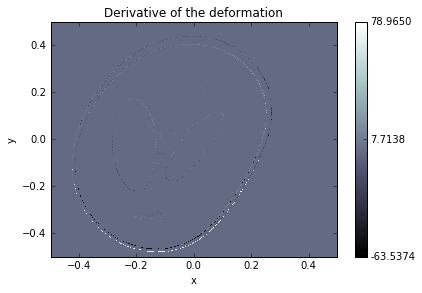

In [48]:
deriv_deform = deformation.derivative(alpha)(beta)
fig = deriv_deform.show('Derivative of the deformation')

Testing the adjoint of the derivative with another phantom from the gallery:

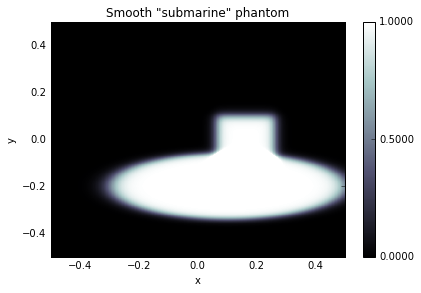

In [50]:
submarine = odl.util.phantom.submarine_phantom(image_space)
fig = submarine.show('Smooth "submarine" phantom')

[array([ 0.07325747,  0.07354512,  0.07383096, ...,  0.00376764,
        0.00370741,  0.00364799]), array([ 0.00472334,  0.00474881,  0.00477429, ...,  0.00477429,
        0.00474881,  0.00472334])]

[-0.42574253 -0.42545488 -0.42516904 ...,  0.50276764  0.50270741
  0.50264799]

[-0.49427666 -0.49225119 -0.49022571 ...,  0.49977429  0.50174881
  0.50372334]
[array([ 0.07325747,  0.07354512,  0.07383096, ...,  0.00376764,
        0.00370741,  0.00364799]), array([ 0.00472334,  0.00474881,  0.00477429, ...,  0.00477429,
        0.00474881,  0.00472334])]

[-0.42574253 -0.42545488 -0.42516904 ...,  0.50276764  0.50270741
  0.50264799]

[-0.49427666 -0.49225119 -0.49022571 ...,  0.49977429  0.50174881
  0.50372334]


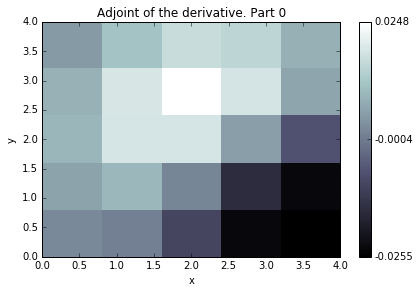

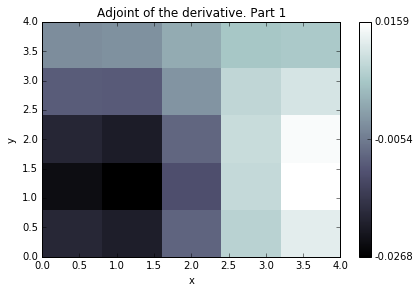

In [51]:
adj_deriv_deform = deformation.derivative(alpha).adjoint(submarine)
fig = adj_deriv_deform.show('Adjoint of the derivative')  # A coefficient vector